In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Usual imports
import sys
import collections
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [3]:
# Training and loading data stolen and adapted from https://github.com/pytorch/examples/blob/master/mnist/main.py

torch.manual_seed(42)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 16

# Load data using Pytorch datasets
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# Log 5 times per epoch
log_interval = len(train_loader)//5

def train(model, device, train_loader, optimizer, scheduler, epoch):
    """
    Training routing. Trains model for one epoch.
    """
    # Set model to train.
    model.train()
    # Iterate over batches in loader
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # Compute loss
        loss = F.cross_entropy(output, target)
        # Apply the gradients
        loss.backward()
        # Step optimizer and lr scheduler
        optimizer.step()
        scheduler.step()
        # Log train loss
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    """
    Test routine. Evaluates model.
    """
    # Set model to eval.
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Sum all the losses.
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            # Find the predicted class.
            pred = output.argmax(dim=1, keepdim=True)
            # Get the number of correctly classified digits.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # Compute desired number of misclassified examples.
    incorrect = (len(test_loader.dataset) - correct)
    print('\nTest set: Average loss: {:.4f}, Error rate: {}/{} ({:.1f}%)\n'.format(
        test_loss, incorrect, len(test_loader.dataset),
        100. * incorrect / len(test_loader.dataset)))


In [4]:
# PatchesNet implemented according to https://openreview.net/pdf?id=SkfMWhAqYQ
# Deliberately made model much simpler than author's implementation https://github.com/wielandbrendel/bag-of-local-features-models/

class PatchesNet(nn.Module):
    """
    Computes scores of each class for patches of images.
    First it creates embedding of each pixel according to a very small neighbourhood.
    Then a convolutional kernel is applied to each of the patches. We use stride=kernel size to isolate the patches.
    Finally the linear layer is used to get scores of each class and these scores are log_softmaxed and averaged across patches.
    
    Using log_softmax instead of softmax is really important - softmax prevents network to learn anything.
    """
    
    def __init__(self, kernel_size=7, channels=[20,50], num_classes=10):
        super(PatchesNet, self).__init__()
        self.kernel_size = kernel_size
        self.num_classes = num_classes
        # Embed into vector size 20 using only closest neighbours.
        self.conv1 = nn.Conv2d(1, channels[0], 3, 1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels[0])
        # Patch embeddings
        self.conv2 = nn.Conv2d(20, channels[1], kernel_size, kernel_size)
        self.bn2 = nn.BatchNorm2d(channels[1])
        # Patch classification
        self.fc1 = nn.Linear(channels[1], num_classes)
        
        # Store intermediate results for debug
        self.patches_scores = None

    def forward(self, x):
        """
        :param torch.Tensor x: Input batch of shape [batch_size, 28, 28]
        :rtype: torch.Tensor 
        :return Logits of each class for the batch. Shape [batch_size, 10]
        """
        # Embed pixels
        x = F.relu(self.bn1(self.conv1(x)))
        # Embed patches
        x = F.relu(self.bn2(self.conv2(x)))
        # Change dimensions so that the the channels are right after batch dimension.
        x = F.relu(self.fc1(x.permute(0,2,3,1)))
        # Squeeze the x and y dimensions. Shape is [batch_size,patches_num**2, num_classes]
        x = x.view([batch_size,(28//self.kernel_size)**2, self.num_classes])

        # Compute log_softmax of scores of patches.
        x = F.log_softmax(x, dim=2)
        # Store the resulting scores for debug later.
        self.patches_scores = x
        
        # Average voting of each patch
        return torch.mean(x, dim=1)
    

In [7]:
# Set kernel size to 7 to get a reasonable amount of information to each patch
kernel_size = 7

model = PatchesNet(kernel_size=kernel_size).to(device)
# Use SGD as optimizer
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.5)
# Employ cyclical learning rate, with base lr=0.08 and highest lr=0.08
# Make it go up and down during one epoch
scheduler = CyclicLR(optimizer, 0.02, 0.08, step_size_up=len(train_loader)/2)

# Try that the output of the model is what we expect
batch_x, batch_label = next(iter(train_loader))
model(batch_x.cuda()).size()

torch.Size([16, 10])

In [8]:
# Train for a couple of epochs, validate after each epoch 
for epoch in range(1, 5):
    train(model, device, train_loader, optimizer, scheduler, epoch)
    test(model, device, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282128
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.071261
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.333004
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.479862
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.211648

Test set: Average loss: 0.1637, Error rate: 481/10000 (4.8%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.019394
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.020468
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.441444
Train Epoch: 2 [36000/60000 (60%)]	Loss: 0.400497
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.042639

Test set: Average loss: 0.1225, Error rate: 368/10000 (3.7%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.247712
Train Epoch: 3 [12000/60000 (20%)]	Loss: 0.036874
Train Epoch: 3 [24000/60000 (40%)]	Loss: 0.153036
Train Epoch: 3 [36000/60000 (60%)]	Loss: 0.320944
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.020319

Test set: Average loss: 0.1122, Error rate: 361/10000 (3.6%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.041772
Train Epoch: 4 [12000/60000 (20

In [9]:
# Let's inspect how the patches work.
# We will plot the voting of each of the patches to see if it makes any sense.

# Set the model to eval.
model.eval()
# Get some data
batch_x, batch_label = next(iter(test_loader))
# Model predictions
model_pred = model(batch_x.cuda())
# Upsample to get the original resolution
up = nn.Upsample(scale_factor=kernel_size, mode='nearest')

In [10]:
# Find an error
idx = torch.argmax(batch_label.cuda() != torch.argmax(model_pred, dim=1))
batch_label.cuda() != torch.argmax(model_pred, dim=1)
# Or just choose and image from the batch
idx = 1

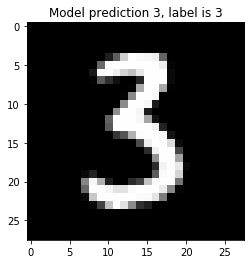

In [11]:
# Show the image
plt.title("Model prediction {}, label is {}".format(torch.argmax(model_pred[idx]), batch_label[idx]))
plt.imshow(1-batch_x[idx].squeeze(), cmap='Greys')

In [15]:
# Upsample the patches to get the same pixels as the original image
patches = model.patches_scores[idx].view(1,28//kernel_size,28//kernel_size,10).permute(0,3,1,2)
patches_big = up(patches).squeeze().permute(1,2,0)

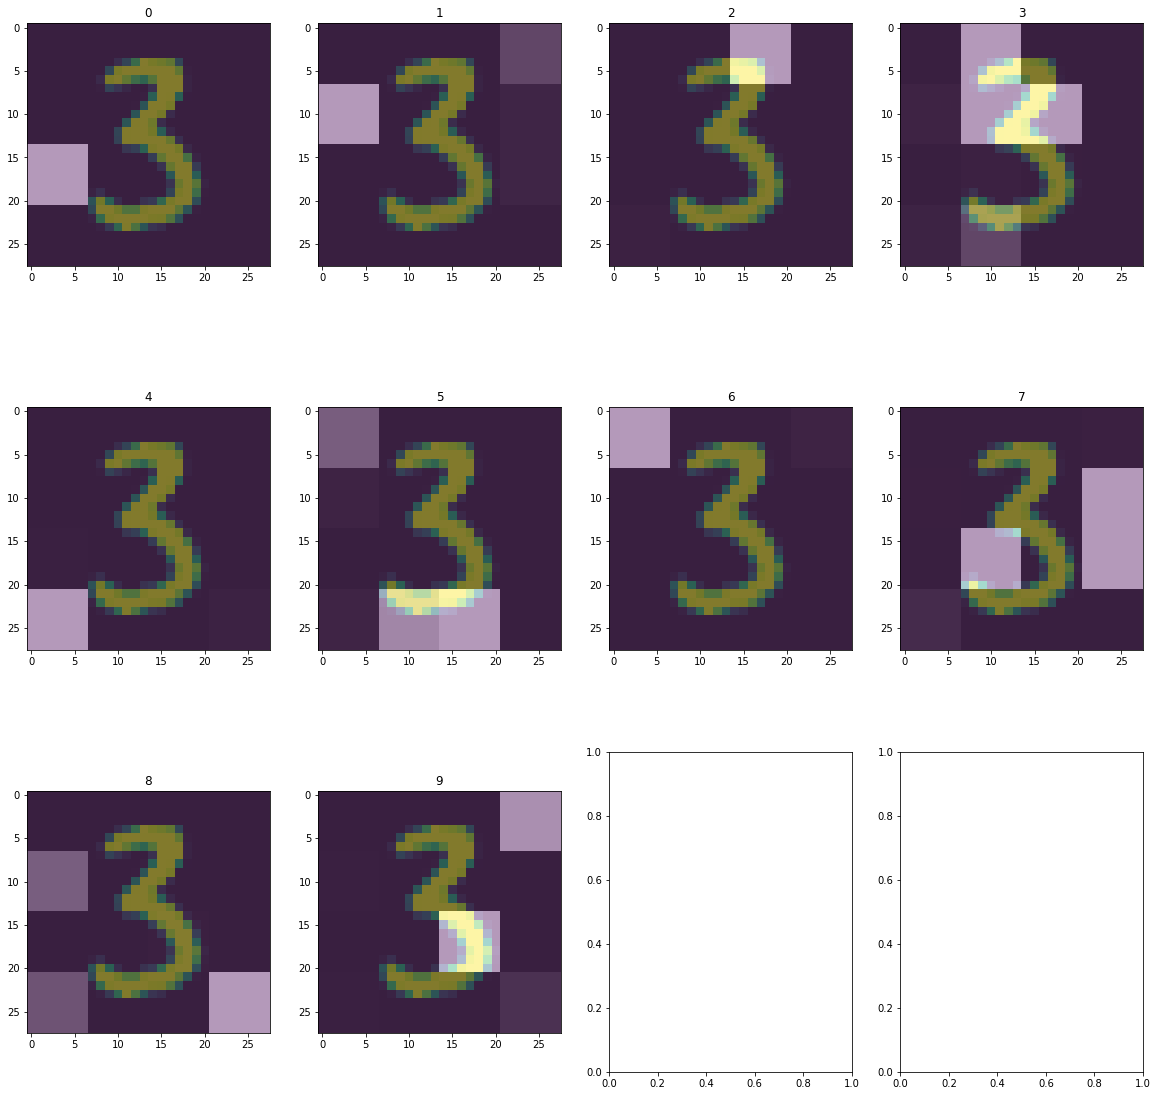

In [16]:
# Plot the voting of patches for each class
plt.subplots(3,4, figsize=(20,20))
img = batch_x[idx].squeeze()
for i in range(10):
    plt.subplot(3,4, i+1)
    plt.title(str(i))
    # Revert the log_softmax back to softmax and invert the mask
    plt.imshow(1-torch.exp(patches_big[:,:,i]).detach().cpu(), cmap='Greys', alpha=0.8)
    plt.imshow(img, alpha=0.4)
plt.show()

In [17]:
# Check that the results corresponds to real model output.
torch.argmax(torch.mean(patches.squeeze().view(10,16),dim=1))

tensor(3, device='cuda:0')